**AlexNet**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Simplified AlexNet Model
class SimplifiedAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimplifiedAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
# CIFAR-10 Data Loading
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initialize the network
net = SimplifiedAlexNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
# Training
train_losses = []
val_losses = []
train_acc = []
val_acc = []
num_epochs = 10
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)

    # Validation
    net.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(test_loader))
    val_acc.append(100 * correct_val / total_val)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%, ' +
          f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_acc[-1]:.2f}%')

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)


Epoch 1, Train Loss: 1.3066, Train Accuracy: 52.73%, Val Loss: 1.1699, Val Accuracy: 58.38%
Epoch 2, Train Loss: 1.1170, Train Accuracy: 60.08%, Val Loss: 1.0692, Val Accuracy: 61.86%
Epoch 3, Train Loss: 0.9926, Train Accuracy: 64.78%, Val Loss: 1.0005, Val Accuracy: 65.62%
Epoch 4, Train Loss: 0.8968, Train Accuracy: 68.56%, Val Loss: 0.8821, Val Accuracy: 69.35%
Epoch 5, Train Loss: 0.8159, Train Accuracy: 71.43%, Val Loss: 0.8789, Val Accuracy: 69.21%
Epoch 6, Train Loss: 0.7591, Train Accuracy: 73.34%, Val Loss: 0.8556, Val Accuracy: 71.35%
Epoch 7, Train Loss: 0.6988, Train Accuracy: 75.80%, Val Loss: 0.8218, Val Accuracy: 71.82%
Epoch 8, Train Loss: 0.6506, Train Accuracy: 77.18%, Val Loss: 0.7901, Val Accuracy: 73.93%
Epoch 9, Train Loss: 0.6127, Train Accuracy: 78.52%, Val Loss: 0.7906, Val Accuracy: 73.61%
Epoch 10, Train Loss: 0.5714, Train Accuracy: 79.95%, Val Loss: 0.7905, Val Accuracy: 73.12%


In [ ]:
# Reporting number of parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'Total number of parameters: {total_params}')

original_alexnet_params = 62378344  # Number of parameters in original AlexNet
print(f'Difference in parameters from original AlexNet: {original_alexnet_params - total_params}')

Total number of parameters: 56826698
Difference in parameters from original AlexNet: 5551646


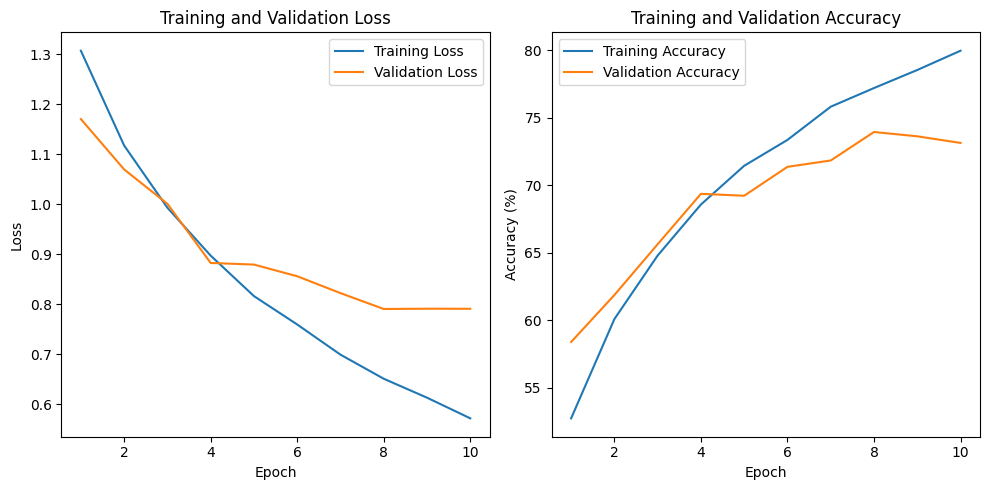

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_acc, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.7312, Precision: 0.7431178631473572, Recall: 0.7312000000000001, F1 Score: 0.7333861919389613


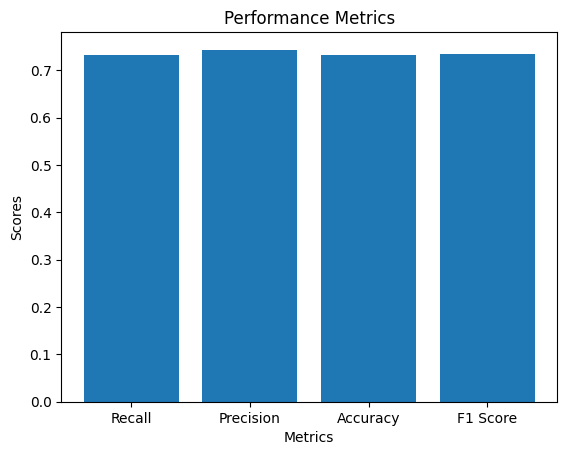

In [ ]:
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

# Plotting Recall, Precision, Accuracy, F1 Score
metrics = [recall, precision, accuracy, f1]
labels = ['Recall', 'Precision', 'Accuracy', 'F1 Score']

plt.bar(labels, metrics)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics')
plt.show()




**with dropout**

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Train Loss: 1.6163, Train Accuracy: 38.97%, Val Loss: 1.3691, Val Accuracy: 49.47%
Epoch 2, Train Loss: 1.2104, Train Accuracy: 56.56%, Val Loss: 1.0699, Val Accuracy: 62.75%
Epoch 3, Train Loss: 1.0061, Train Accuracy: 64.39%, Val Loss: 0.9709, Val Accuracy: 66.04%
Epoch 4, Train Loss: 0.8765, Train Accuracy: 69.19%, Val Loss: 0.9147, Val Accuracy: 68.96%
Epoch 5, Train Loss: 0.7811, Train Accuracy: 72.86%, Val Loss: 0.7824, Val Accuracy: 72.58%
Epoch 6, Train Loss: 0.7045, Train Accuracy: 75.47%, Val Loss: 0.7762, Val Accuracy: 72.95%
Epoch 7, Train Loss: 0.6453, Train Accuracy: 77.42%, Val Loss: 0.7453, Val Accuracy: 74.87%
Epoch 8, Train Loss: 0.6017, Train Accuracy: 79.22%, Val Loss: 0.7686, Val Accuracy: 74.10%
Epoch 9, Train Loss: 0.5557, Train Accuracy: 80.69%, Val Loss: 0.7363, Val Accuracy: 75.38%
Epoch 10, Train Loss: 0.5129, Train Accuracy: 82.14%, Val Loss: 0.7269, Val Accuracy: 75.60%
Epo

<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

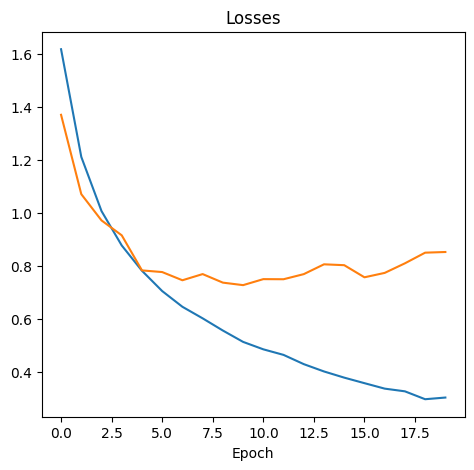

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetCIFAR10, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Adjusted kernel size and stride
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),  # Adjusted kernel size
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize the model, loss function, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = AlexNetCIFAR10().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# CIFAR-10 Data Loading
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Initialize lists for plotting
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# Training loop with dropout and plotting included
num_epochs = 20  # Adjust the number of epochs
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct, total = 0, 0
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    net.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%')

# Plot training and validation losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel
